# Transcriptome (scRNA-seq data)

We show an example of scRNA-seq data produced by 10X Chromium. We are using scRNA-seq data `10k Human PBMCs, 3’ v3.1, Chromium Controller` (11,485 cells and 36,601 genes) from [10X Genomics Datasets](https://www.10xgenomics.com/resources/datasets). The test data is directly available from `Feature / cell matrix HDF5 (filtered)` in [here](https://www.10xgenomics.com/resources/datasets/10k-human-pbmcs-3-v3-1-chromium-controller-3-1-high) (registration required).

We use [scanpy](https://scanpy.readthedocs.io/en/stable/) to read/write 10X data. Import numpy and scanpy in addlition to screcode.

In [1]:
import screcode
import scanpy as sc
import warnings
warnings.simplefilter('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/) object. 

In [2]:
input_filename = 'data/10k_PBMC_3p_nextgem_Chromium_Controller_filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(input_filename)
adata.layers["Raw"] = adata.X.toarray()
adata

AnnData object with n_obs × n_vars = 11485 × 36601
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'Raw'

## Apply RECODE
Apply RECODE to the count matrix. The **anndata** or **ndarray** data format is available. 

In [3]:
recode = screcode.RECODE()
adata = recode.fit_transform(adata)

start RECODE for scRNA-seq data
end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': 12439, '#non-significant genes': 8969, '#silent genes': 11490, 'ell': 64, 'Elapsed time': '0h 0m 31s 920ms', 'solver': 'randomized', '#test_data': 2297}


With anndata format, outputs of RECODE are included in anndata objects:
- denoised matrix -> adata.obsm['RECODE']
- noise variance -> adata.var['noise_variance_RECODE']
- normalized variance (NVSN variance) ->  adata.var['normalized_variance_RECODE']
- clasification of genes (significant/non-significant/silent) ->  adata.var['significance_RECODE']

In [4]:
adata

AnnData object with n_obs × n_vars = 11485 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'noise_variance', 'normalized_variance', 'significance_RECODE'
    uns: 'RECODE_essential'
    layers: 'Raw', 'RECODE', 'RECODE_NVSN'

### Performance check

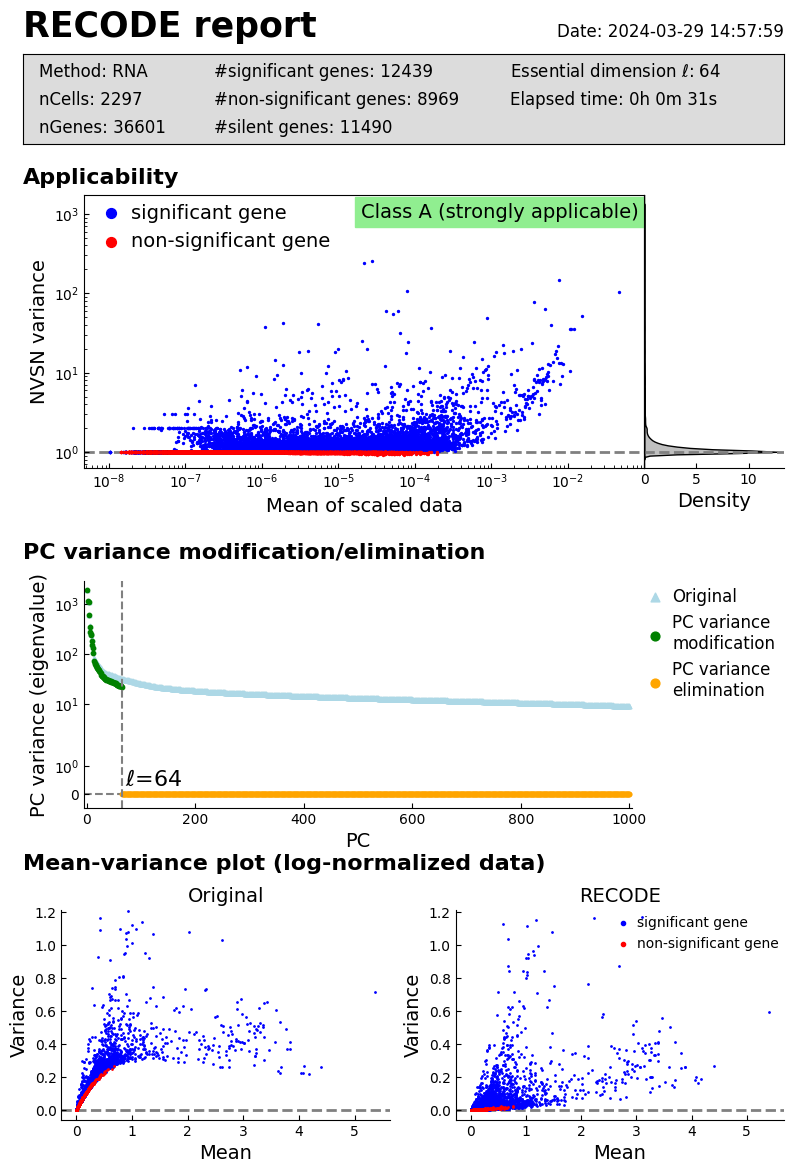

In [5]:
recode.report()

## Downstream analysis based on [scanpy](https://scanpy.readthedocs.io/en/stable/index.html)

### log normalization

In [6]:
target_sum = 1e4
adata = recode.lognormalize(adata,target_sum=target_sum)

Normalized data are stored in "RECODE_norm" and "RECODE_log"


In [7]:
adata.X = adata.layers["RECODE_log"]

### PCA

In [8]:
sc.tl.pca(adata, svd_solver='arpack')

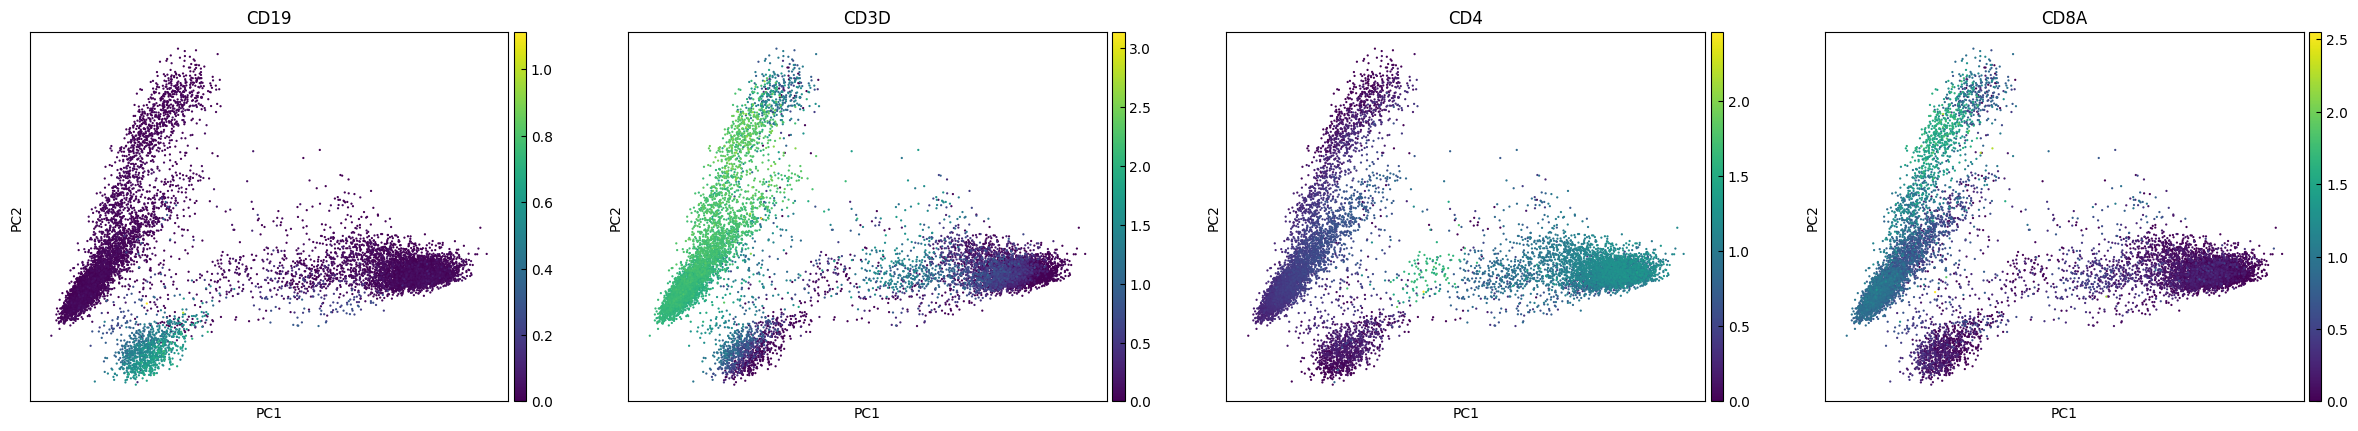

In [9]:
plot_genes = ['CD19','CD3D','CD4','CD8A']
sc.pl.pca(adata, color=plot_genes)

### UMAP

Note that we do not use the PCA dimentionaly reduction as a preprocessing of UMAP (`n_pca=0`). 

In [10]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=0)
sc.tl.umap(adata)

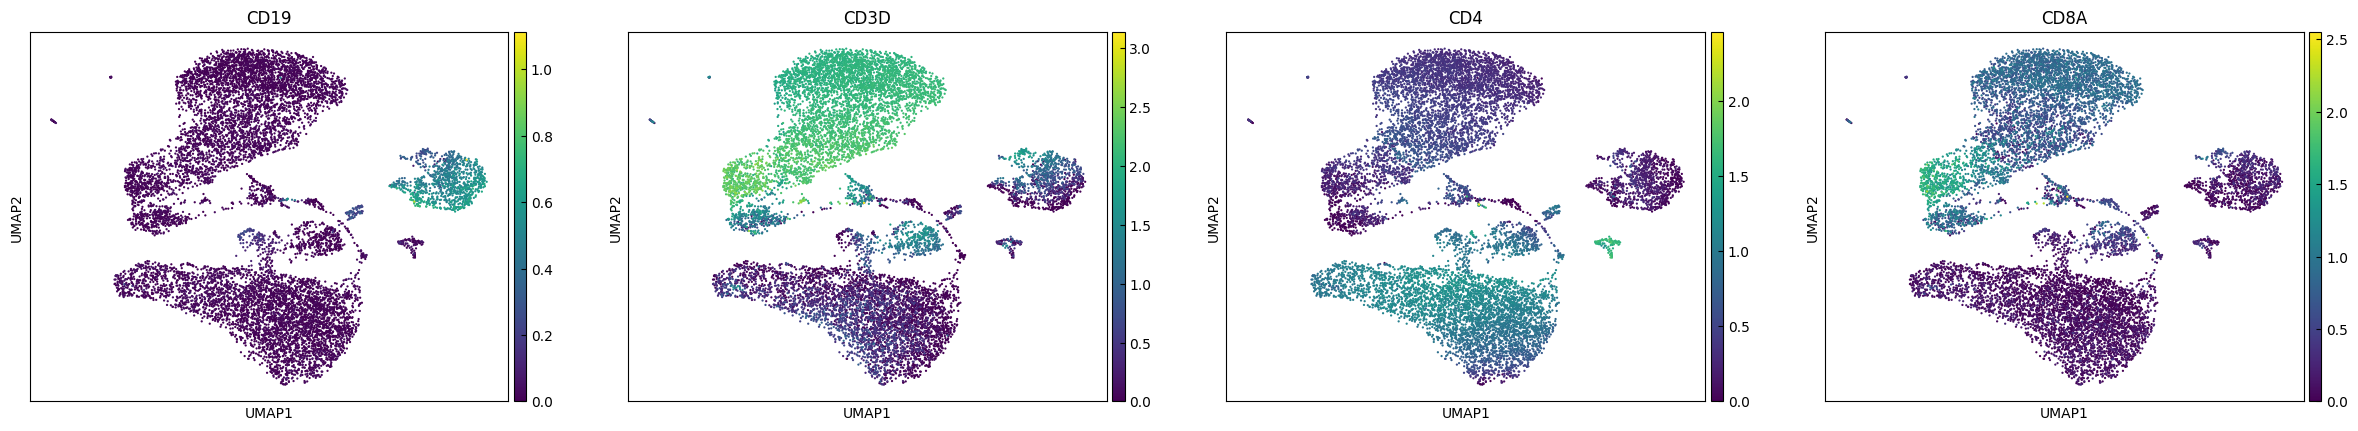

In [11]:
sc.pl.umap(adata, color=plot_genes)

## Clustering

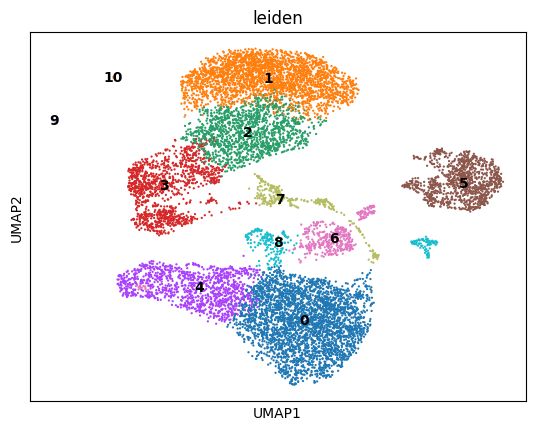

In [12]:
sc.tl.leiden(adata,resolution=0.3)
sc.pl.umap(adata, color=['leiden'],legend_loc='on data')

## Find marker genes

In [13]:
import numpy as np
threshold_mean = 0.5
adata_marker = adata[:,np.mean(adata.X,axis=0)>threshold_mean]
sc.tl.rank_genes_groups(adata_marker, 'leiden', method='t-test')

In [14]:
marker_genes = list(adata_marker.uns['rank_genes_groups']['names'][0]) # The top marker genes for each cluster

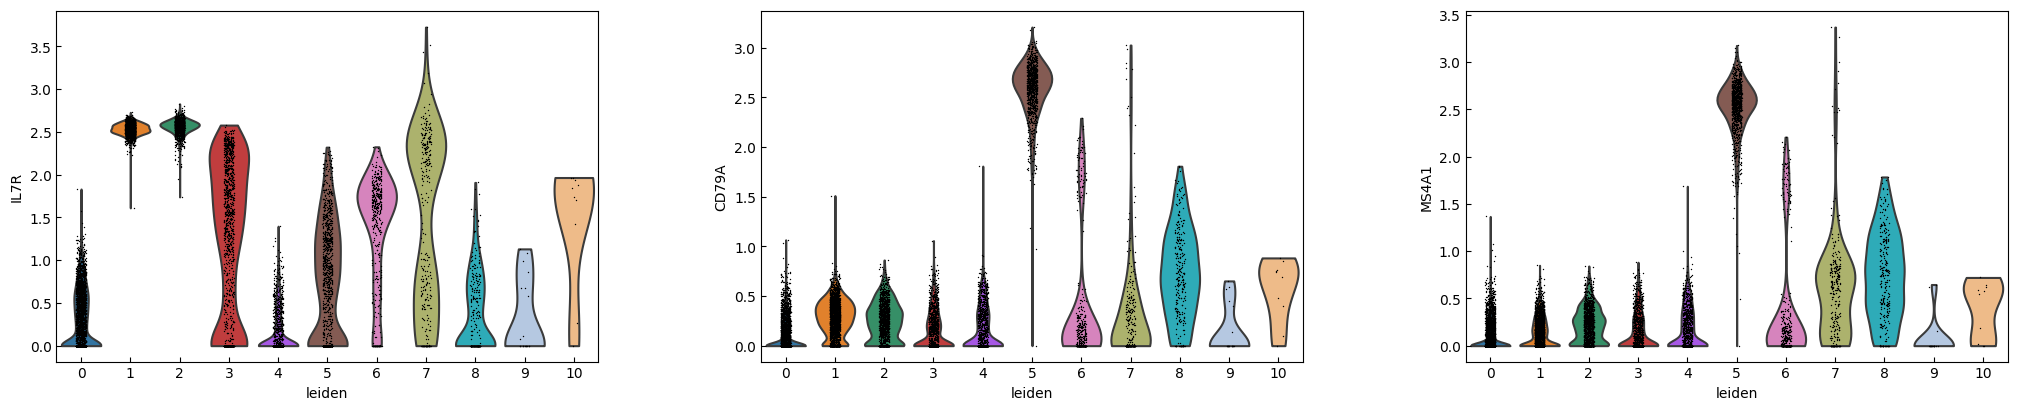

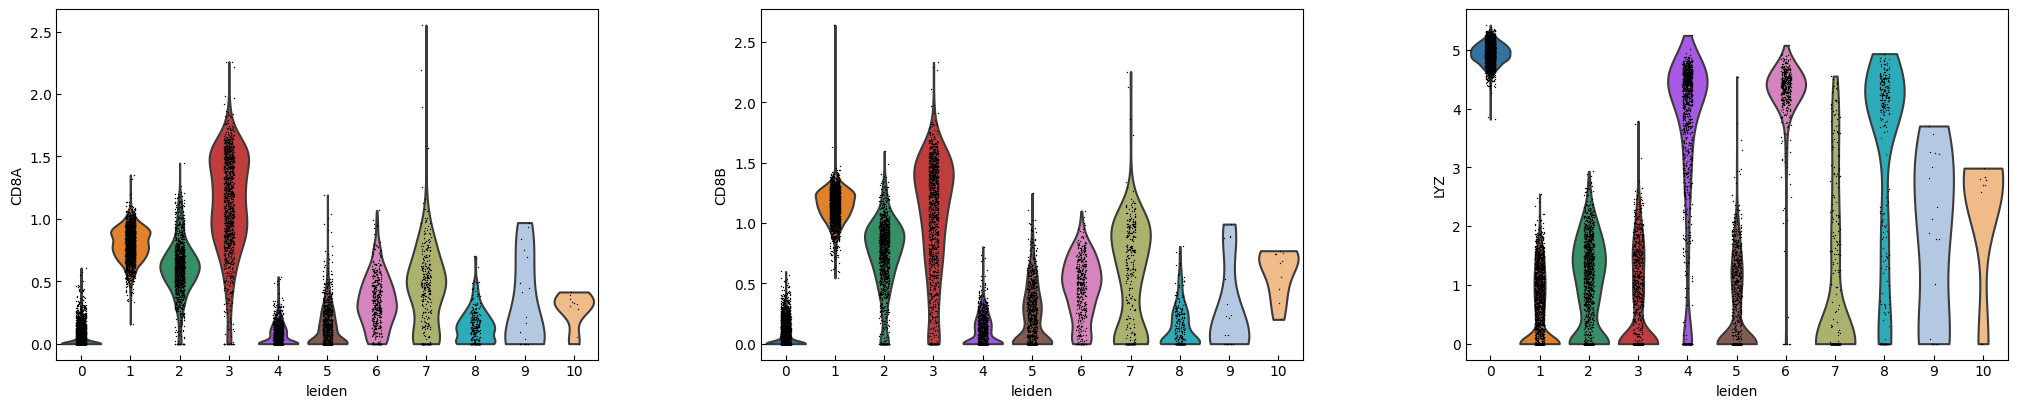

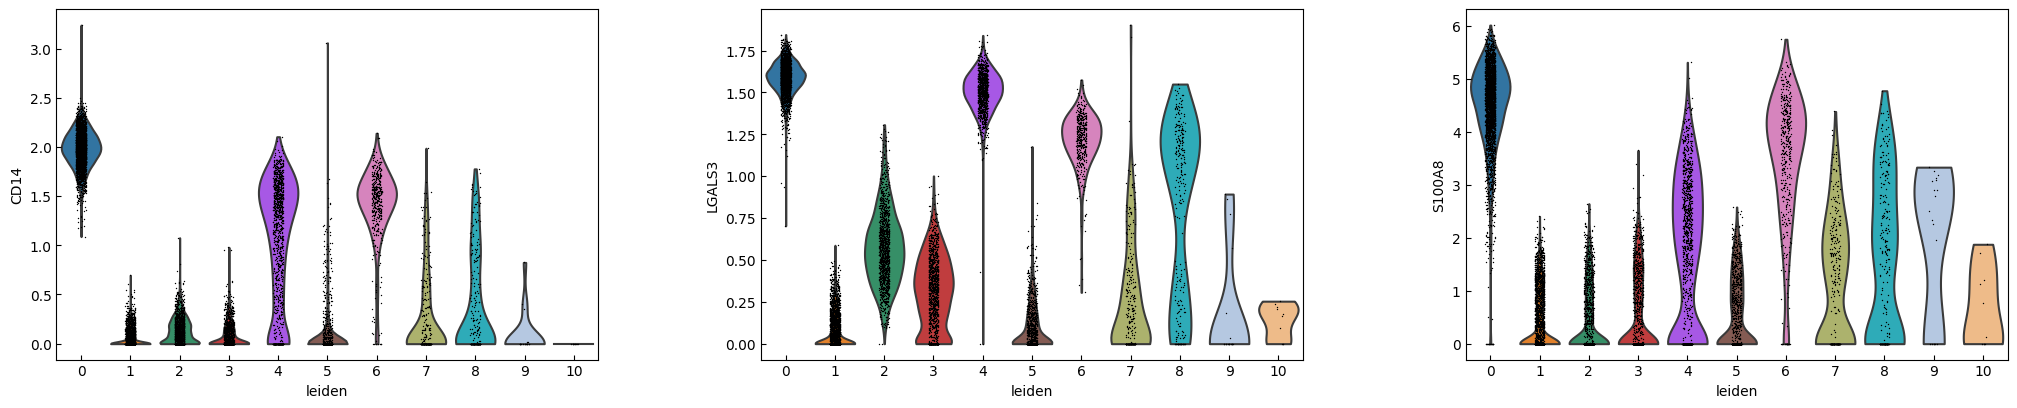

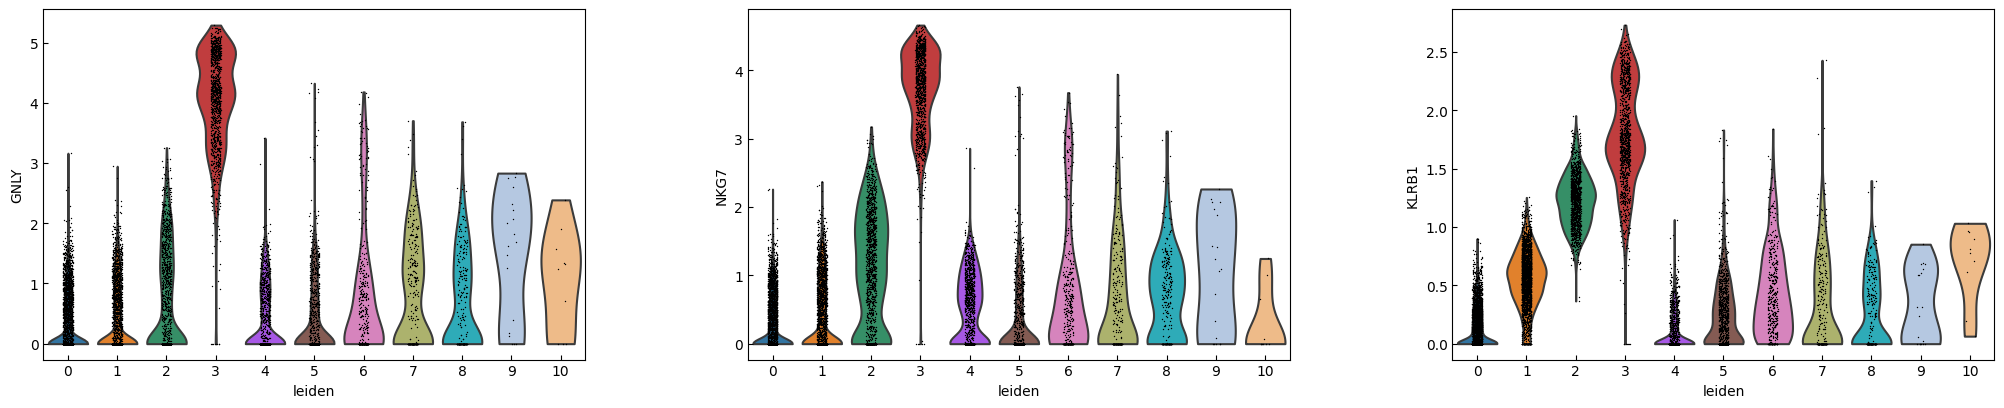

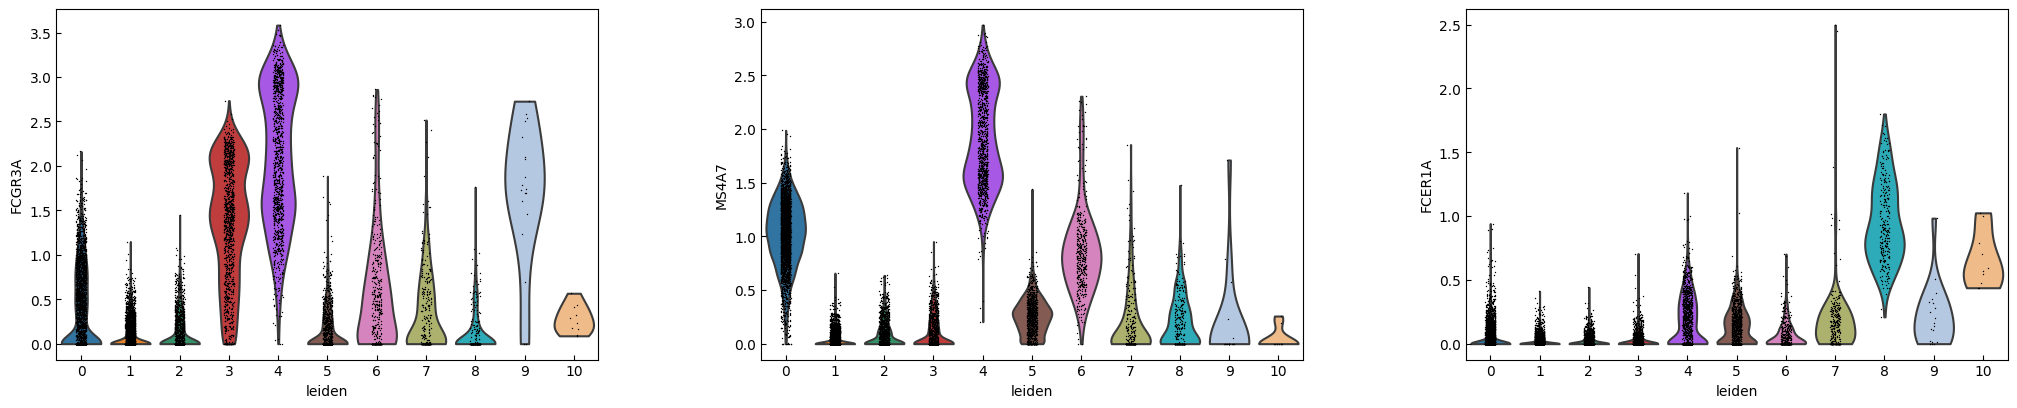

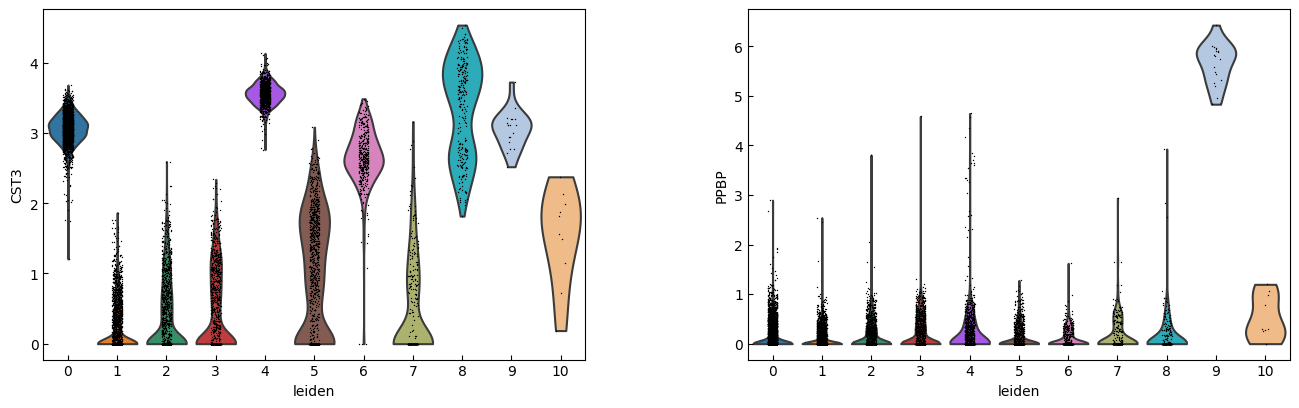

In [15]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']
adata.var_names_make_unique()
n_cols = 3
for i in range(0, len(marker_genes),n_cols):
    sc.pl.violin(adata, marker_genes[i:i+n_cols], groupby='leiden')

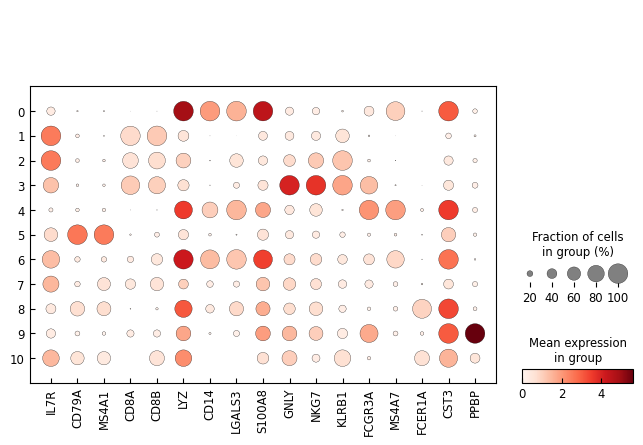

In [16]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden',expression_cutoff=0.5)

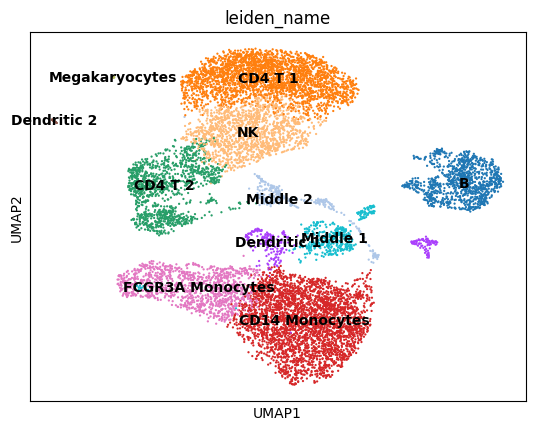

In [17]:
new_cluster_names = [
    'CD14 Monocytes','CD4 T 1', 'NK', 'CD4 T 2','FCGR3A Monocytes',
    'B', 'Middle 1', 'Middle 2', 'Dendritic 1', 'Dendritic 2', 'Megakaryocytes']
adata.obs["leiden_name"] = [new_cluster_names[int(i)] for i in adata.obs["leiden"].values]
sc.pl.umap(adata, color='leiden_name', legend_loc='on data')

### Gene expression distributions

Normalized data are stored in "Raw_norm" and "Raw_log"


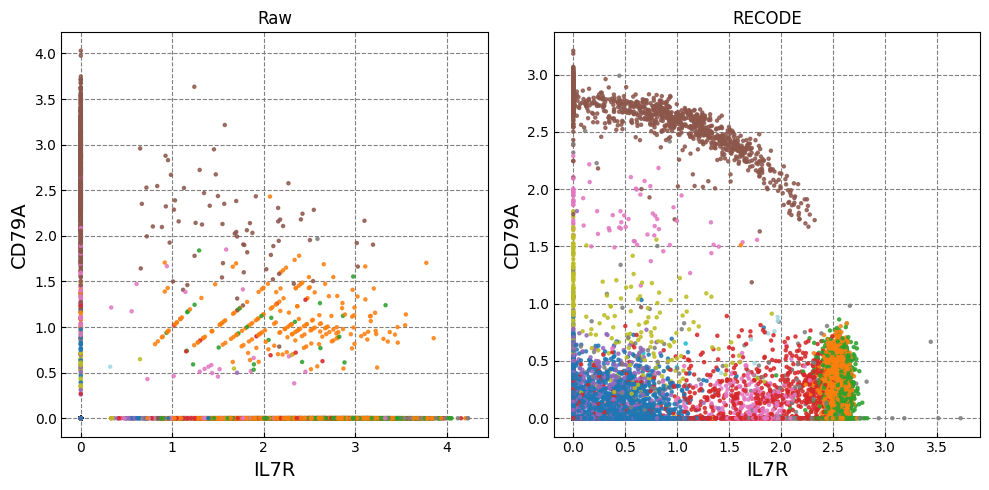

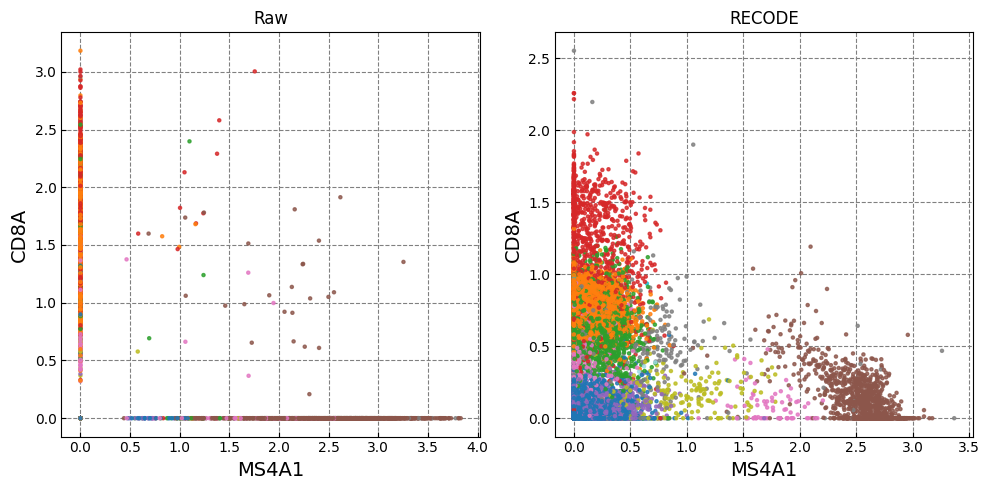

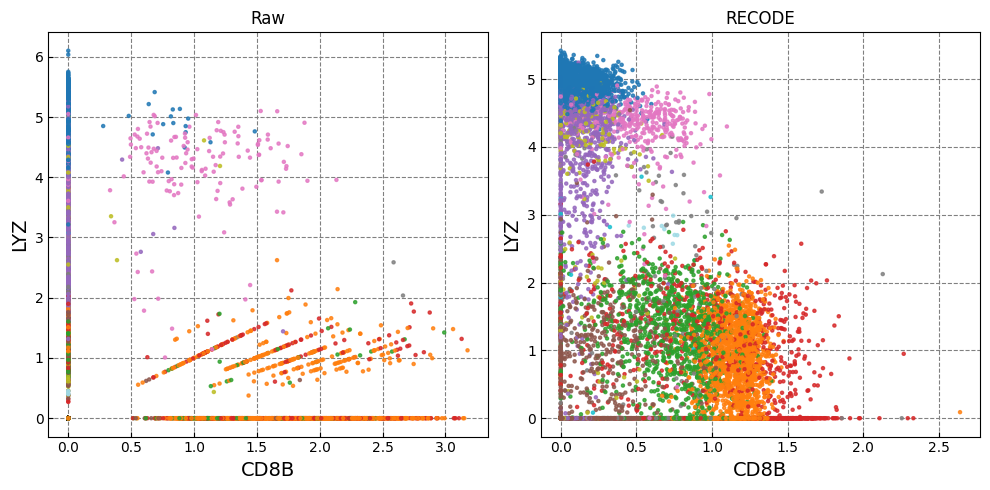

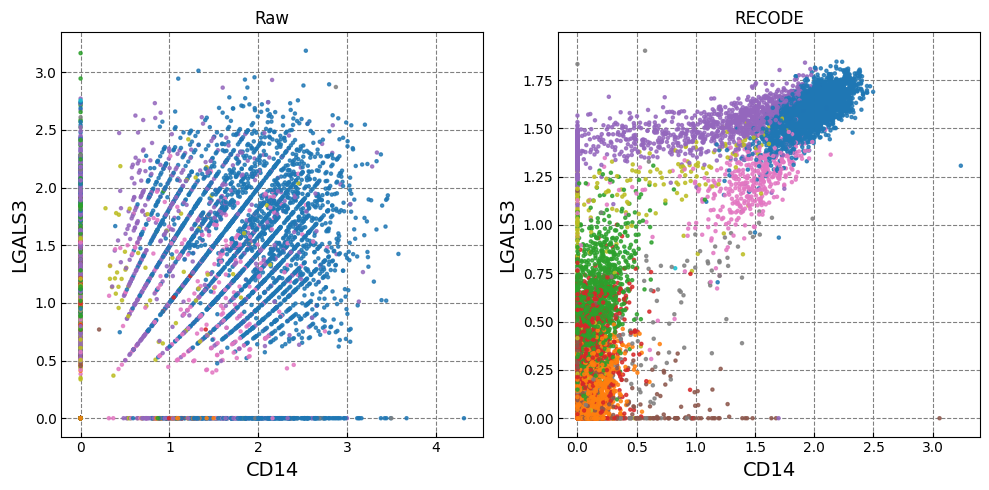

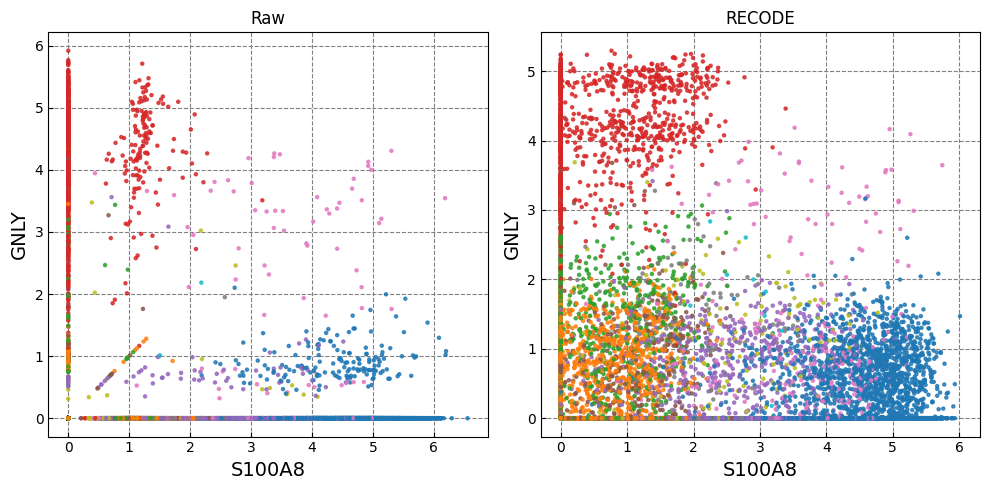

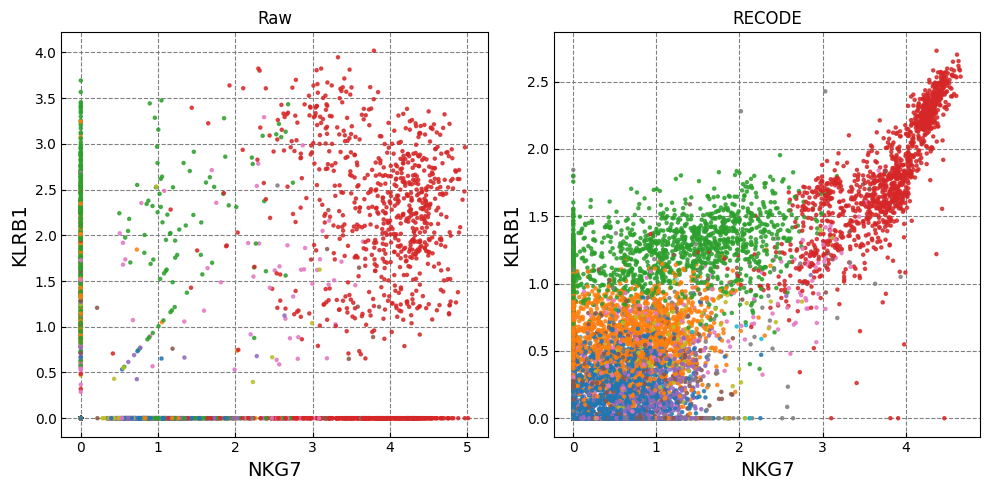

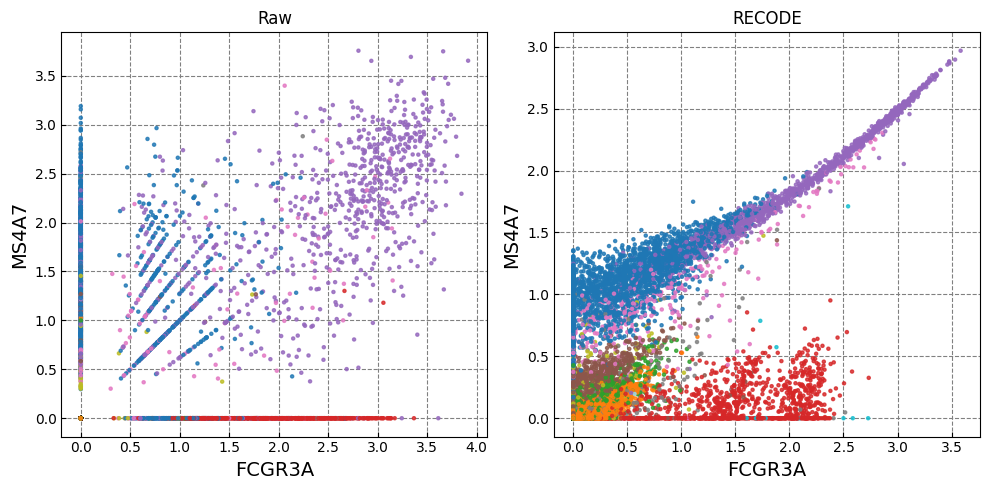

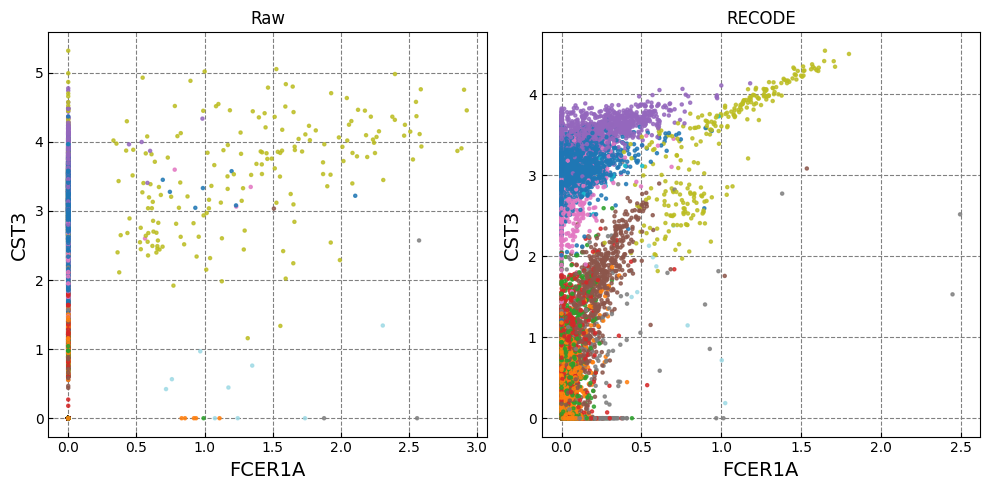

In [18]:
import matplotlib.pyplot as plt

size_factor = 1e4
alpha = 0.8
ps = 5
fontsize_label = 14
adata = recode.lognormalize(adata,target_sum=target_sum,key="Raw")
plot_data = [adata.layers["Raw_log"],adata.X]
names = ['Raw','RECODE']
color = np.array(adata.obs['leiden'].values,dtype=int)

n_col_genes = 1

n_plot = len(names)
n_ax =  n_plot * n_col_genes
for k in range(0, len(marker_genes),2):
    if k+1 >= len(marker_genes): break
    fig,ax = plt.subplots(1,n_ax,figsize=(5*n_ax,5),tight_layout=True)
    for i in range(n_plot):
        i_ax = i
        g1_,g2_ = marker_genes[k],marker_genes[k+1]
        ax[i_ax].scatter(plot_data[i][:,adata.var.index==g1_], plot_data[i][:,adata.var.index==g2_], c=color, alpha=alpha,zorder=10,s=ps,cmap='tab20')
        ax[i_ax].set_xlabel(g1_,fontsize=fontsize_label)
        ax[i_ax].set_ylabel(g2_,fontsize=fontsize_label)
        ax[i_ax].set_title(names[i])
        ax[i_ax].grid(ls='--',color='gray',zorder=0)

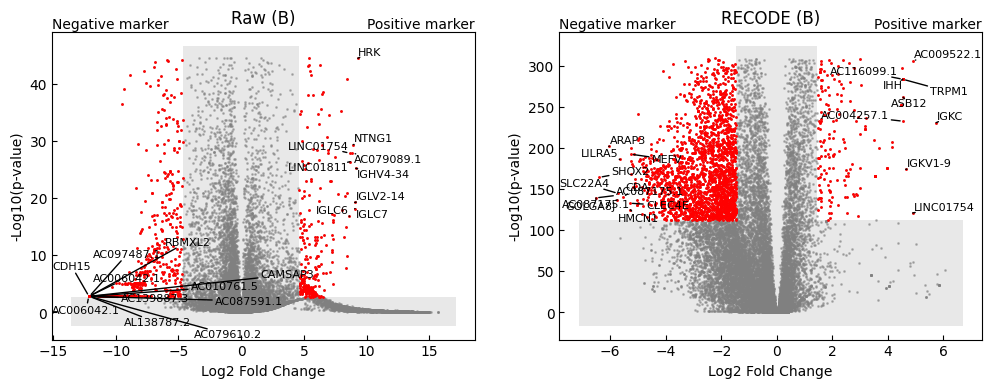

In [19]:
import scipy
import adjustText

def volcano_plot(
    target_cluster,
    clusters = adata.obs["leiden_name"],
    data_key = ["Raw","RECODE"],
    figsize=(6,4),
    to_pt_FC = 80,
    to_pt_pval = 75,
    n_genes = 10,
    fs_genes = 8,
    ):

    fig,ax = plt.subplots(1,2,figsize=(figsize[0]*len(data_key),figsize[1]))

    for i in range(len(data_key)):
        key = data_key[i]
        idx_target = clusters == target_cluster
        idx_others = clusters != target_cluster
        data_FC = adata.layers[key+"_norm"]
        g1_mean_ = np.mean(data_FC[idx_target],axis=0)
        g2_mean_ = np.mean(data_FC[idx_others],axis=0) 
        g1_mean_[g1_mean_ == 0] = 1
        g2_mean_[g2_mean_ == 0] = 1
        FC = np.log2(g1_mean_ / g2_mean_)
        data_pval = adata.layers[key+"_norm"]
        pvalue = scipy.stats.ttest_ind(data_pval[idx_target], data_pval[idx_others])[1]
        pvalue_log = -np.log10(pvalue)
        pvalue_log_max = np.max(pvalue_log[(np.isinf(pvalue_log)==False) & (np.isnan(pvalue_log)==False)])*1.05
        pvalue_log_plot =np.copy(pvalue_log) 
        pvalue_log_plot[np.isinf(pvalue_log)] = pvalue_log_max
        ax_ = ax[i]
        to_FC = np.percentile(np.abs(FC),to_pt_FC)
        to_pval = np.percentile(pvalue_log[(np.isnan(pvalue_log)==False) & (np.isinf(pvalue_log)==False)],to_pt_pval)
        ax_.scatter(FC,pvalue_log,s=1,color="gray",alpha=0.5)
        idx_ = (pvalue_log>to_pval) & (np.abs(FC)>to_FC) & (np.isnan(pvalue_log)==False) & (np.isinf(pvalue_log)==False)
        ax_.scatter(FC[idx_], pvalue_log[idx_], color="red", s=1)
        ax_.fill_between(
            [-to_FC, to_FC],
            to_pval,
            ax_.get_ylim()[1],
            facecolor="lightgray",
            alpha=0.5,
            zorder=0,
        )
        ax_.fill_between(
            [ax_.get_xlim()[0], ax_.get_xlim()[1]],
            ax_.get_ylim()[0],
            to_pval,
            facecolor="lightgray",
            alpha=0.5,
            zorder=0,
        )
        idx_ = (pvalue_log>to_pval) & (np.isnan(pvalue_log)==False) & (np.isinf(pvalue_log)==False)
        idx_mgenes = np.argsort(FC[idx_])
        texts = []
        for j in range(n_genes):
            text_ = ax_.text(
                FC[idx_][idx_mgenes][j],
                pvalue_log[idx_][idx_mgenes][j],
                adata.var.index[idx_][idx_mgenes][j],
                color="k",
                fontsize=fs_genes,
            )
            texts = np.append(texts, text_)
            text_ = ax_.text(
                FC[idx_][idx_mgenes][-j],
                pvalue_log[idx_][idx_mgenes][-j],
                adata.var.index[idx_][idx_mgenes][-j],
                color="k",
                fontsize=fs_genes,
            )
            texts = np.append(texts, text_)
        adjustText.adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k'),ax=ax_)
        ax_.set_title("%s (%s)" % (key,target_cluster))
        ax_.set_xlabel('Log2 Fold Change')
        ax_.set_ylabel('-Log10(p-value)')
        ax_.text(1,1,"Positive marker",  ha='right', va='bottom',transform=ax_.transAxes)
        ax_.text(0,1,"Negative marker",  ha='left', va='bottom',transform=ax_.transAxes)

volcano_plot(target_cluster = "B")